#Replicating Miles' Code

In [1]:
## [User Mods]
import Wavelength_To_RGB
import PARAMS
import process_optaa
from process_optaa import get_dev_coeffs, apply_dev, apply_tscorr, Process_Optaa
#Externaml Mods
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import numpy as np
import pickle
import xarray as xr
import pandas as pd
import dask.array as da
from scipy.stats import mstats
#OOI Mods
from ooi_data_explorations.data_request import data_request
from ooi_data_explorations.common import m2m_request, m2m_collect, get_deployment_dates
from ooi_data_explorations.common import get_vocabulary, load_gc_thredds, update_dataset, CONFIG, ENCODINGS
from ooi_data_explorations.uncabled.process_optaa import optaa_datalogger
from ooi_data_explorations.common import list_deployments
from ooi_data_explorations.uncabled.process_optaa import adjusted_dates
from OOI_Data_Functions import Download_Data, Download_OOI_Data, Sync_Profiles, Process_Profile, Create_Profiles, Get_SPKIR_Wavelengths
from OOI_Data_Functions import Plot_OOI_Profile, Plot_Hoffmuller

In [76]:
#setip information to identify the specific snesor/data wanted
#Site-Node will be same for all instruments from Oregon Shelf Profiler
site = 'CE02SHSP'
node = 'SP001'
method = 'recovered_cspp'
assembly = 'profiler'
deployment = '15'

#Specify the instrument
#Will use OPTAA Spectrophotometer for this example
instrument = 'OPTAA'
sensor = '04-OPTAAJ000'
stream = 'optaa_dj_cspp_instrument_recovered'
#tag = '.*deployment0015.*OPTAA.*\\.nc$'
tag = '.*OPTAA.*\\.nc$'

#Specify start/stop dates
start="2019-08-13"
stop="2019-10-13"

#cwingard code, not usre if necessary yet
use_dask = True                               # OPTAA data requires the use of dask to handle large data volumes
level = 'nsif'                                # local directory name, level below site
instrmt = 'optaa'

In [3]:
#Imports Download_Data function from Miles' code, uses m2m request
optaa_dat = Download_Data(site, node, sensor, method, deployment, stream, tag)

Requesting:
	refdes: CE02SHSP-SP001-04-OPTAAJ000
	method: recovered_cspp
	stream: optaa_dj_cspp_instrument_recovered
	from 2019-08-13T18:25:00.000Z to 2019-10-20T18:57:00.000Z
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [01:03<00:00,  6.31it/s]


In [74]:
optaa_dat

<xarray.Dataset>
Dimensions:                       (time: 55904, wavelength: 85)
Coordinates:
  * wavelength                    (wavelength) int32 0 1 2 3 4 ... 81 82 83 84
  * time                          (time) datetime64[ns] 2019-08-13T19:03:52.8...
Data variables: (12/29)
    external_temp_raw             (time) uint16 41014 41015 ... 38599 38592
    c_signal_counts               (time, wavelength) uint16 690 810 ... 3012
    deployment                    (time) int32 15 15 15 15 15 ... 15 15 15 15 15
    a_signal_counts               (time, wavelength) uint16 545 649 ... 6568
    lat                           (time) float64 44.64 44.64 ... 44.64 44.64
    int_ctd_pressure              (time) float64 76.29 76.29 ... 0.823 0.7473
    ...                            ...
    a_reference_dark_counts       (time) uint16 472 472 472 472 ... 472 473 473
    suspect_timestamp             (time) int8 0 0 0 1 0 0 0 0 ... 0 0 0 0 1 0 0
    depth                         (time) float64 75.66 75.66 ... 0.8163 0.7412
    sea_water_temperature         (time) float64 7.72 7.72 7.719 ... 12.1 12.1
    internal_temp                 (time) float64 7.649 7.677 ... 9.973 9.978
    external_temp                 (time) float64 7.395 7.393 ... 11.26 11.27
Attributes: (12/67)
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [75]:
optaa_profiles = Create_Profiles(optaa_dat, dt_sep=120, process_profile=True)

In [77]:
optaa_profs = Process_Profile(optaa_profiles, drop_time=60, chris_method=True)

AttributeError: 'list' object has no attribute 'where'

In [37]:
optaa_profs

<xarray.Dataset>
Dimensions:                       (time: 74, wavelength: 85)
Coordinates:
  * wavelength                    (wavelength) int32 0 1 2 3 4 ... 81 82 83 84
  * time                          (time) datetime64[ns] 2019-08-28T12:20:45.3...
Data variables: (12/28)
    external_temp_raw             (time) float64 4.1e+04 4.099e+04 ... 3.878e+04
    c_signal_counts               (time, wavelength) float64 658.5 ... 5.129e+03
    deployment                    (time) float64 15.0 15.0 15.0 ... 15.0 15.0
    a_signal_counts               (time, wavelength) float64 540.0 ... 7.268e+03
    lat                           (time) float64 44.64 44.64 ... 44.64 44.64
    int_ctd_pressure              (time) float64 74.75 69.7 ... 1.151 2.142
    ...                            ...
    a_reference_dark_counts       (time) float64 472.9 473.0 ... 472.0 472.6
    suspect_timestamp             (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    depth                         (time) float64 -74.0 -69.0 -53.0 ... -1.0 -2.0
    sea_water_temperature         (time) float64 7.772 7.802 ... 14.17 14.07
    internal_temp                 (time) float64 7.574 7.607 ... 9.482 9.337
    external_temp                 (time) float64 7.41 7.434 ... 11.15 10.97
Attributes: (12/67)
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [38]:
savefile_head = 'OOI_data'
optaa_savefile = f'{savefile_head}_{deployment}_optaa.p'
optaa_profs_savefile = f'{savefile_head}_{deployment}_optaa_profes.p'

In [39]:
pickle.dump(optaa_profs, open(optaa_profs_savefile, 'wb'))
pickle.dump(optaa_dat, open(optaa_savefile, 'wb'))

In [4]:
optaa_dat = pickle.load(open(optaa_savefile, 'rb'))
optaa_profiles = pickle.load(open(optaa_profiles_savefile, 'rb'))

In [5]:
optaa_dat

<xarray.Dataset>
Dimensions:                       (time: 55904, wavelength: 85)
Coordinates:
  * wavelength                    (wavelength) int32 0 1 2 3 4 ... 81 82 83 84
  * time                          (time) datetime64[ns] 2019-08-13T19:03:52.8...
Data variables: (12/27)
    external_temp_raw             (time) uint16 41014 41015 ... 38599 38592
    c_signal_counts               (time, wavelength) uint16 690 810 ... 3012
    deployment                    (time) int32 15 15 15 15 15 ... 15 15 15 15 15
    a_signal_counts               (time, wavelength) uint16 545 649 ... 6568
    lat                           (time) float64 44.64 44.64 ... 44.64 44.64
    int_ctd_pressure              (time) float64 76.29 76.29 ... 0.823 0.7473
    ...                            ...
    a_signal_dark_counts          (time) uint16 625 625 625 625 ... 645 645 645
    c_reference_counts            (time, wavelength) uint16 863 994 ... 8197
    a_reference_dark_counts       (time) uint16 472 472 472 472 ... 472 473 473
    suspect_timestamp             (time) int8 0 0 0 1 0 0 0 0 ... 0 0 0 0 1 0 0
    depth                         (time) float64 75.66 75.66 ... 0.8163 0.7412
    sea_water_temperature         (time) float64 7.72 7.72 7.719 ... 12.1 12.1
Attributes: (12/67)
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

<class 'list'>


In [7]:
optical_absorption = optaa_dat.variables['optical_absorption'].data
wavelength_a = optaa_dat.variables['wavelength_a'].data
beam_attenuation = optaa_dat.variables['beam_attenuation'].data
depth = optaa_dat.variables['depth'].data
dt = optaa_dat.variables['time'].data

In [55]:
optical_absorption = optaa_profs.variables['optical_absorption'].data
wavelength_a = optaa_profs.variables['wavelength_a'].data
beam_attenuation = optaa_profs.variables['beam_attenuation'].data
depth = optaa_profs.variables['depth'].data
dt = optaa_profs.variables['time'].data

In [63]:
print(depth)

[-74. -69. -53. -58. -64. -63. -65. -68. -54. -59. -48. -49. -66. -62.
 -57. -67. -60. -52. -51. -46. -50. -16. -61. -19. -70. -47. -56. -18.
 -17. -26. -14. -23. -55. -73. -21. -71. -36. -43. -28. -44. -33.  -8.
 -12. -20. -34. -22. -13. -27. -31. -72. -42. -10. -38. -25. -32. -24.
 -41. -29. -35. -15.  -6. -37. -11. -40. -39.  -9. -30.  -4.  -5.  -7.
  -3. -45.  -1.  -2.]


In [65]:
depth_mask = (optaa_profs['depth'] <= -5) & (optaa_profs['depth'] >= -10)
depth_mask

<xarray.DataArray 'depth' (time: 74)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False,  True,  True, False, False,
       False, False])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-28T12:20:45.384882930 ... 2019-09-...

In [66]:
optical_absorption = optaa_profs.variables['optical_absorption'][depth_mask]
optical_absorption.shape

(6, 85)

In [48]:
calib_instance = get_dev_coeffs(optaa_profs)

num_wavelengths 85 <xarray.DataArray 'num_wavelengths' ()>
array(85.)
Coordinates:
    time     datetime64[ns] 2019-08-28T12:20:45.384882930
Attributes:
    _FillValue:   0
    comment:      Number of output wavelengths
    precision:    0
    long_name:    Number of Wavelengths
    units:        1
    coordinates:  lat depth lon time


In [31]:
coeffs = calib_instance.__dict__

In [33]:
print(coeffs.keys())

dict_keys(['coeff_file', 'coeffs', 'dev_file', 'hdr_url', 'tca_url', 'tcc_url'])


In [32]:
apply_dev(optaa_dat, coeffs)

KeyError: 'a_offsets'

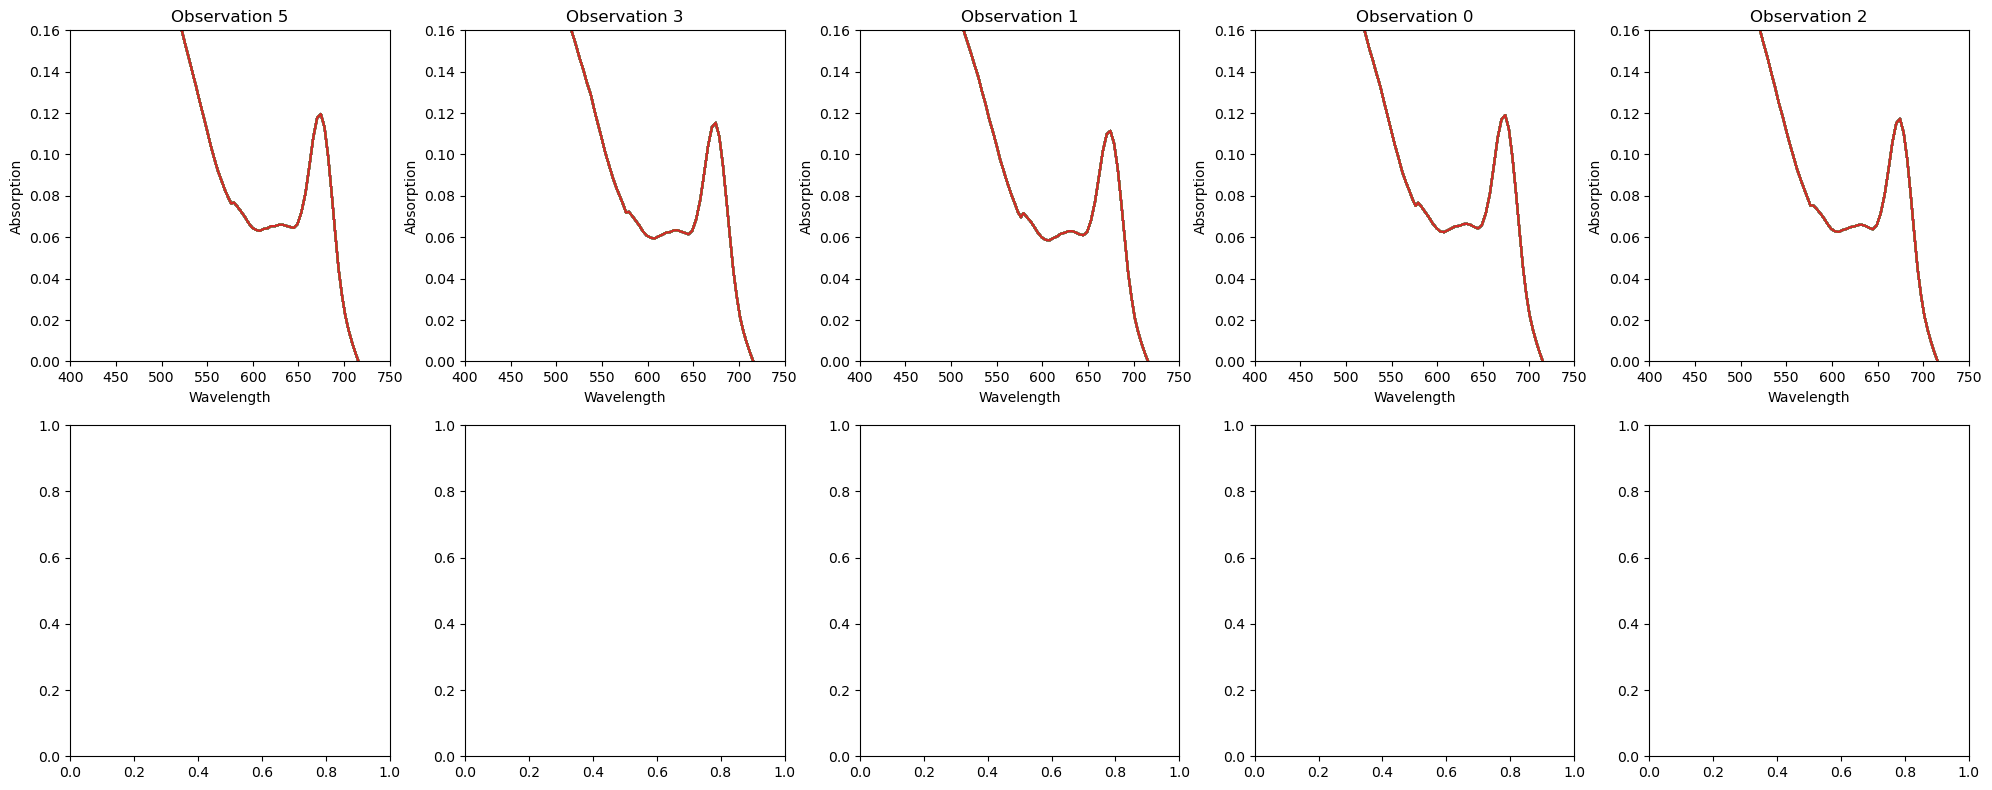

In [70]:
num_observations = optical_absorption.shape[0]
random_indices = da.random.choice(num_observations, size=5, replace=False)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, idx in enumerate(random_indices.compute()):
    row_idx = i // 5
    col_idx = i % 5
    ax = axes[row_idx, col_idx]
    ax.plot(wavelength_a, optical_absorption[idx])
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Absorption')
    ax.set_title(f'Observation {idx}')
    ax.set_ylim([0.00, 0.16])
    ax.set_xlim([400,750])
plt.tight_layout()
plt.show()

In [68]:
mean_optical_absorption = np.nanmean(optical_absorption, axis=0)
mean_optical_absorption = mean_optical_absorption[np.isfinite(mean_optical_absorption)]

# CDOM Absorption

In [71]:
f_a = .85    #fraction of water free absorption
lam0 = 400
S_CDOM =.021  #units of nm-1

In [72]:
nspectra = optical_absorption.shape[0]
aOOI_lam0 = np.empty(nspectra)
aCDOM = np.zeros((nspectra, wavelength_a.size))

In [73]:
for j in range(nspectra):
    aOOI_lam0[j]=np.interp(lam0, wavelength_a, optical_absorption[j,:])
    aCDOM[j,:] = f_a*aOOI_lam0[j]* np.exp(-S_CDOM*(wavelength_a - lam0))

ValueError: object too deep for desired array

In [53]:
import numpy as np

# Subtract CDOM absorption from optical absorption
true_absorption = np.subtract(optical_absorption, aCDOM)

num_observations = true_absorption.shape[0]
random_indices = da.random.choice(num_observations, size=10, replace=False)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, idx in enumerate(random_indices.compute()):
    row_idx = i // 5
    col_idx = i % 5
    ax = axes[row_idx, col_idx]
    ax.plot(wavelength_a, true_absorption[idx])
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Absorption')
    ax.set_title(f'Observation {idx}')
    ax.set_ylim([0.00, 0.16])
    ax.set_xlim([400,750])
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (74,85) (74,6290) 

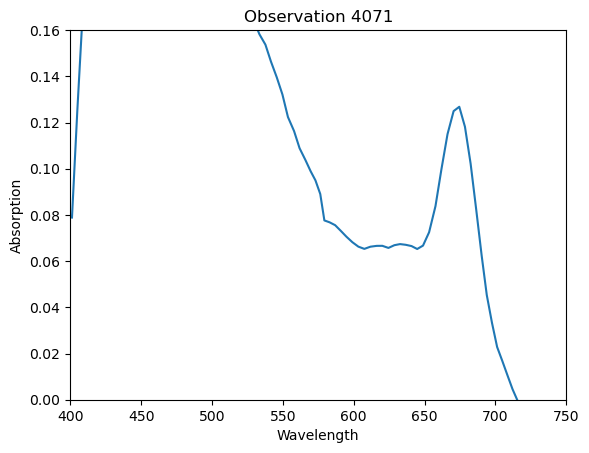

In [21]:
i = 4071
plt.xlabel('Wavelength')
plt.ylabel('Absorption')
plt.title(f'Observation {i}')
plt.ylim([0.00, 0.16])
plt.xlim([400,750])
plt.plot(wavelength_a, true_absorption[i,:])
plt.show()

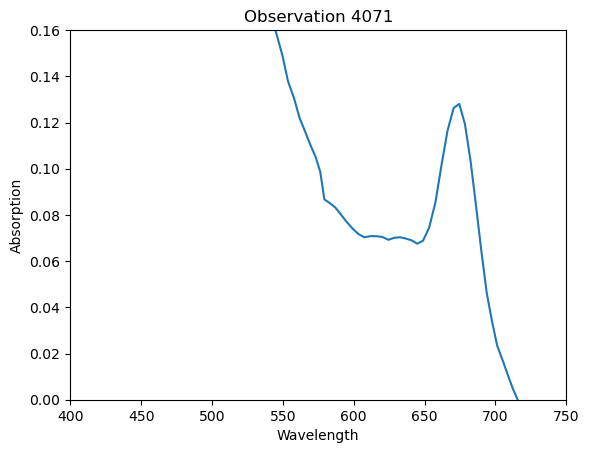

In [17]:
plt.xlabel('Wavelength')
plt.ylabel('Absorption')
plt.title(f'Observation {i}')
plt.ylim([0.00, 0.16])
plt.xlim([400,750])
plt.plot(wavelength_a, optical_absorption[i,:])
plt.show()

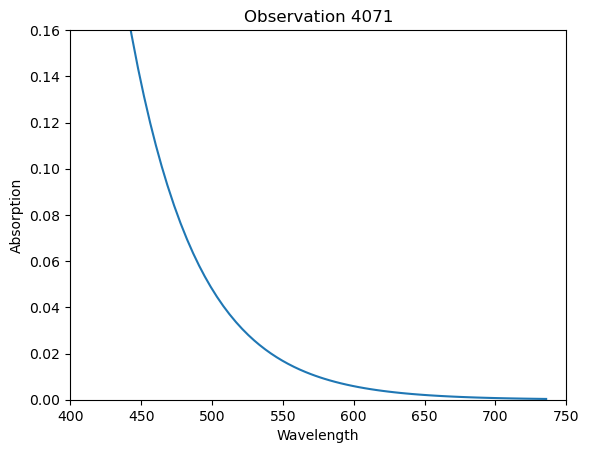

In [18]:
plt.xlabel('Wavelength')
plt.ylabel('Absorption')
plt.title(f'Observation {i}')
plt.ylim([0.00, 0.16])
plt.xlim([400,750])
plt.plot(wavelength_a, aCDOM[i,:])
plt.show()

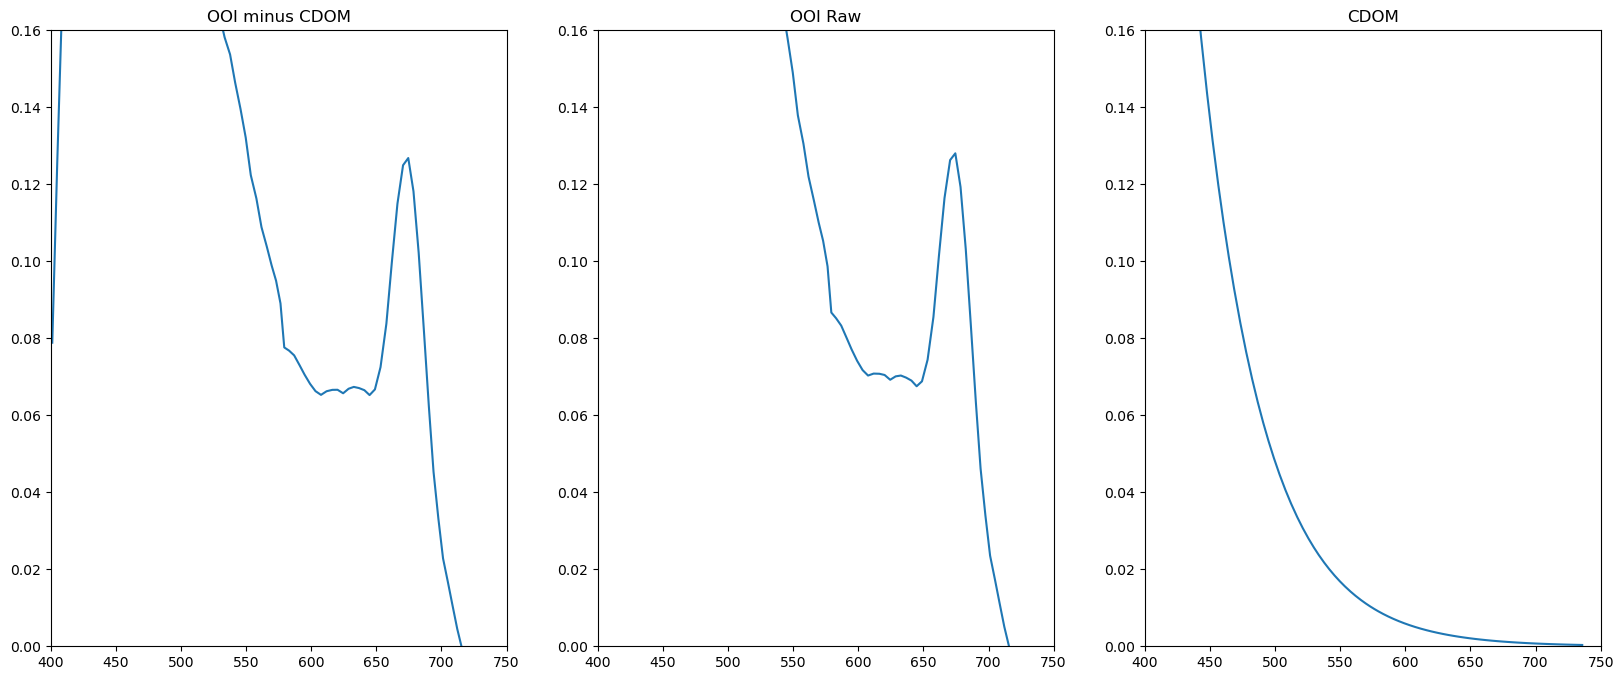

In [19]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axis[0].plot(wavelength_a, true_absorption[i,:])
axis[0].set_title("OOI minus CDOM")
axis[1].plot(wavelength_a, optical_absorption[i,:])
axis[1].set_title("OOI Raw")
axis[2].plot(wavelength_a, aCDOM[i,:])
axis[2].set_title("CDOM")
ax = axis[0]
ax.set_ylim([0.00, 0.16])
ax.set_xlim([400,750])
ax1 = axis[1]
ax1.set_ylim([0.00, 0.16])
ax1.set_xlim([400,750])
ax2 = axis[2]
ax2.set_ylim([0.00, 0.16])
ax2.set_xlim([400,750])
plt.show()

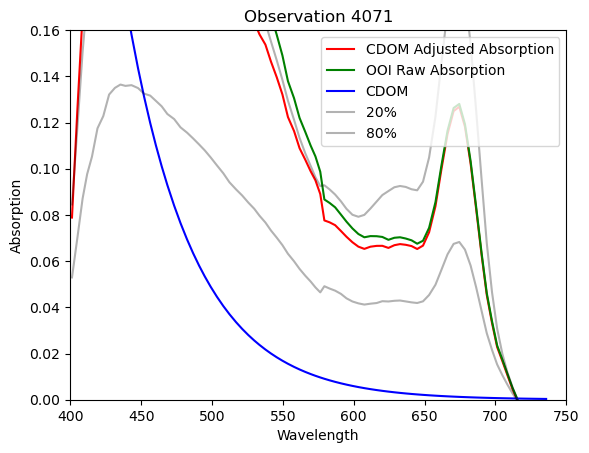

In [22]:
plt.xlabel('Wavelength')
plt.ylabel('Absorption')
plt.title(f'Observation {i}')
plt.ylim([0.00, 0.16])
plt.xlim([400,750])
plt.plot(wavelength_a, true_absorption[i,:], color = 'r', label = 'CDOM Adjusted Absorption')
plt.plot(wavelength_a, optical_absorption[i,:], color = 'g', label = 'OOI Raw Absorption')
plt.plot(wavelength_a, aCDOM[i,:], color = 'b', label = 'CDOM')
quantiles = mstats.mquantiles(true_absorption, prob = [0.20,0.80], axis=0)
labels = ['20%','80%']
for i, q in enumerate(quantiles):
    plt.plot(wavelength_a, q, label=labels[i], color='k' ,alpha = .3)
plt.legend()
plt.show()

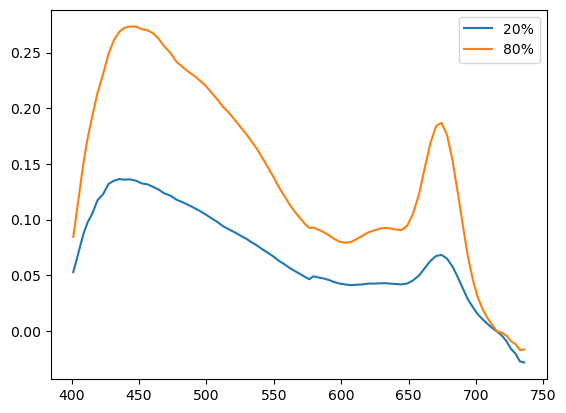

In [100]:
quantiles = mstats.mquantiles(true_absorption, prob = [0.20,0.80], axis=0)
labels = ['20%','80%']
for i, q in enumerate(quantiles):
    plt.plot(wavelength_a, q, label=labels[i])
plt.legend()
plt.show()

In [210]:
Q1 = np.quantile(true_absorption, .2)
Q2 = np.quantile(true_absorption, .8)

ValueError: x and y must have same first dimension, but have shapes (85,) and (1,)

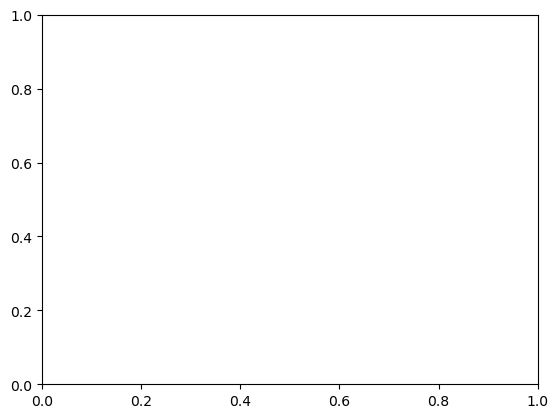

In [211]:
plt.plot(wavelength_a, Q1, 'm--', label = '20%')
plt.plot(wavelength_a, Q2, 'k--', label = '80%')
plt.legend()
plt.show()